In [585]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [70]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

In [5]:
zip_codes = crop_sim.load_zip("33483")
print(zip_codes)

     ZIP  latitude  longitude
0  33483   26.4546   -80.0656


In [13]:
# crop_sim.generate_near()

In [16]:
loca_tasmin, loca_tasmax = crop_sim.load_temperature_data(zip_codes)

In [17]:
print(loca_tasmin)

<xarray.DataArray 'tasmin' (time: 731, lat: 16, lon: 16)> Size: 749kB
[187136 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 6kB 2022-01-01T12:00:00 ... 2024-01-01T12:...
  * lat      (lat) float64 128B 26.03 26.09 26.16 26.22 ... 26.84 26.91 26.97
  * lon      (lon) float64 128B 279.0 279.1 279.2 279.2 ... 279.8 279.9 280.0
Attributes:
    units:    K
    history:   pierce 2023-08-14 09:28:45.882494 /net/mead24/data/LOCA2_CONUS...
    region::  s_east


In [28]:
ecocrop_df = crop_sim.load_ecocrop()

In [46]:


# Select your crop of interest (replace 'Maize' with your desired crop)
# crop_name = 'Allium cepa' #onion
# crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Ipomoea batatas"
crop_name = "Solanum tuberosum" # Potato
bolting = False

tmin, tmax, topt_min, topt_max, gmin, gmax = crop_sim.load_crop_variables(ecocrop_df, crop_name)


In [36]:
zip_codes = crop_sim.add_loca_index(zip_codes, loca_tasmin, loca_tasmax)

In [37]:
print(zip_codes['loca_index'].values)

[(7, 14)]


In [51]:
lat, lon = zip_codes['loca_index'].values[0]

In [40]:
loca_tasmin_smoothed, loca_tasmax_smoothed = crop_sim.smooth_tas(loca_tasmin, loca_tasmax)

In [47]:
daily_suitability = crop_sim.suitability(bolting, loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max)

In [569]:
# print(daily_suitability.isel(lat=lat, lon=lon))

In [62]:
growing_season_suitability = crop_sim.calculate_season_suitability(gmin, gmax, daily_suitability)
optimal_planting_ranges = crop_sim.calculate_optimal_planting_ranges(growing_season_suitability, lat, lon)


In [571]:
view_window = 90
print(optimal_planting_ranges)

{90: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2023-01-17 12:00:00')]], 100: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2023-01-07 12:00:00')]], 110: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-12-28 12:00:00')]], 120: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-12-18 12:00:00')]], 130: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-12-08 12:00:00')]], 140: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-11-28 12:00:00')]], 150: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-11-18 12:00:00')]], 160: [[Timestamp('2022-10-28 12:00:00'), Timestamp('2022-11-08 12:00:00')]]}


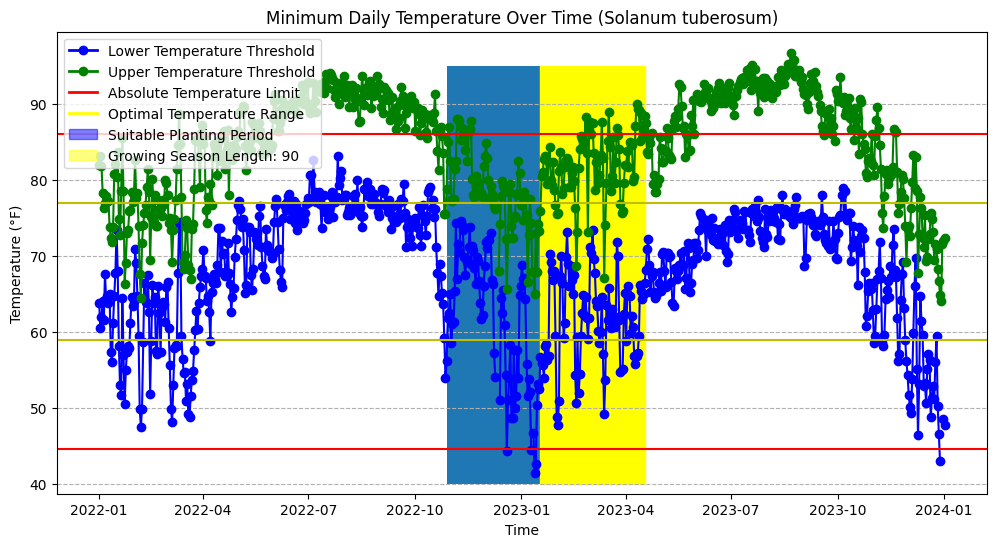

In [65]:
view_window = 90
crop_sim.plot_planting(loca_tasmin_smoothed, loca_tasmax_smoothed, tmin, tmax, topt_min, topt_max, view_window, optimal_planting_ranges, lat, lon, crop_name)


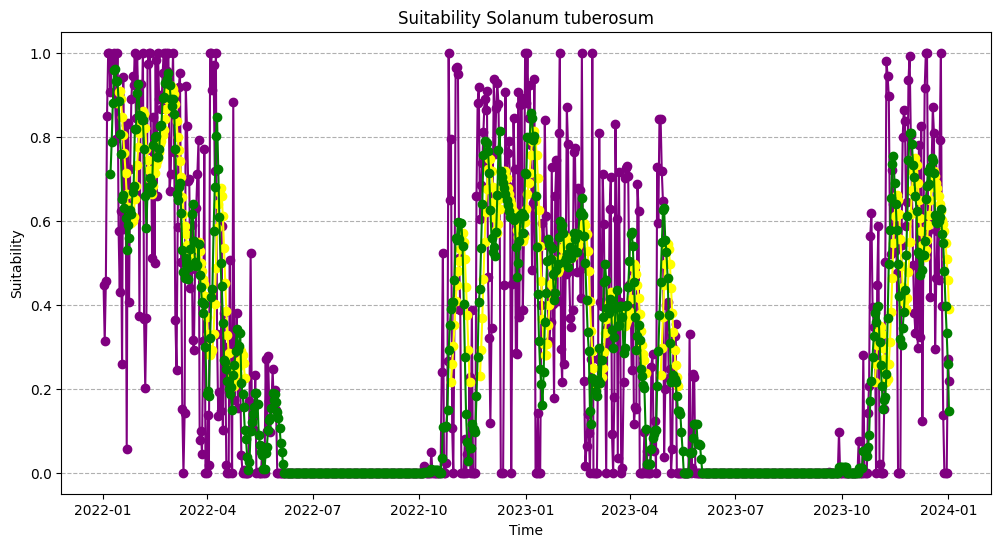

In [69]:
crop_sim.plot_suitability(view_window, growing_season_suitability, daily_suitability, lat, lon, crop_name)

In [87]:
def merge_overlapping_monthday_ranges(date_ranges):
    """Converts date ranges to month-day format and merges overlapping ranges.

    Args:
        date_ranges (list): List of date ranges, each as [start_date, end_date].

    Returns:
        list: List of merged month-day ranges, each as (start_month, start_day, end_month, end_day).
    """

    # month_day_ranges = [(date.month, date.day) for start, end in date_ranges for date in [start, end]]
    # month_day_ranges.sort()  

    month_day_ranges = [(start.month, start.day, end.month, end.day) for [start, end] in date_ranges]

    merged_ranges = []
    current_range = month_day_ranges[0]
    
    for start_month2, start_day2, end_month2, end_day2 in month_day_ranges[1:]:
        start_month1, start_day1, end_month1, end_day1 = current_range
        if end_month1 < start_month1:
            end_month1 += 12
        if end_month2 < start_month2:
            end_month2 += 12
        # Range 1 starts before Range 2 ends, and Range 1 ends after Range 2 starts:
        if ((start_month1 < end_month2 or (start_month1 == end_month2 and start_day1 <= end_day2)) and
            (end_month1 > start_month2 or (end_month1 == start_month2 and end_day1 >= start_day2))):
            # Overlapping range - extend the end
            current_range = (start_month1, start_day1, end_month2, end_day2)
        # Range 1 is fully contained within Range 2:
        elif ((start_month1 >= start_month2 and start_day1 >= start_day2) and
            (end_month1 <= end_month2 and end_day1 <= end_day2)):
            current_range = (start_month2, start_day2, end_month2, end_day2)
        # Range 2 is fully contained within Range 1:
        elif ((start_month2 >= start_month1 and start_day2 >= start_day1) and
            (end_month2 <= end_month1 and end_day2 <= end_day1)):
            current_range = (start_month1, start_day1, end_month1, end_day1)
        else:
            # New range - add the current range and start a new one
            merged_ranges.append(current_range)
            if end_month1 > 12:
                end_month1 -= 12
            if end_month2 > 12:
                end_month2 -= 12
            current_range = (start_month2, start_day2, end_month2, end_day2)

    merged_ranges.append(current_range)  # Add the last range

    return merged_ranges

import pandas as pd
date_ranges = [
    [pd.Timestamp('2024-01-15'), pd.Timestamp('2024-03-10')],
    [pd.Timestamp('2024-02-01'), pd.Timestamp('2024-04-15')],
    [pd.Timestamp('2024-05-01'), pd.Timestamp('2024-05-15')],
    [pd.Timestamp('2023-12-15'), pd.Timestamp('2024-01-20')]  # Wrapped around year end
]

merged_ranges = merge_overlapping_monthday_ranges(date_ranges)
print(merged_ranges)

[(1, 15, 4, 15), (5, 1, 5, 15), (12, 15, 1, 20)]
